<a href="https://colab.research.google.com/github/MatthewTran30/MT/blob/main/FourFactorsAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduction:

In this project, I chose this classifier becuase it played a big role in predicting NBA outcomes based on different features. The chosen classifier’s advantages include interpretability, non-linearity handling, robustness to noise, and scalability. Evaluation metrics such as accuracy, precision, recall, F1-score, and ROC-AUC express the classifier’s quality. Patterns observed in NBA data, such as non-linear relationships and feature importance, justify the use of the selected classifier.

# NBA Four Factors Analysis

## Four Factors

The term is based on what Dean Oliver called the *Four Factors of Basketball Success*, which are:

- Shooting
- Turnovers
- Rebounding
- Free Throws

These are important for any team both on offense and defense, and for that reason we can think that we have 8 factors instead of 4 and they can be obtained from just the box scores. I will explain them a bit more in detail below.

### Shooting
As we all now, the team that gets more points wins basketball games. This factor is measured as the *Effective Field Goal Percentage* (EFG%):

$$
EFG\% = \frac{FGM + 0.5 FG3M}{FGA},
$$

where
- FGM: Field Goals Made
- FG3M: 3-Point Shots Made
- FGA: Field Goal Attempts

### Turnovers
Teams need to take care of the ball to get the best out of their possessions. This factor is measured with the *Turnover Percentage* (TOV%):

$$
TOV\% = \frac{TOV}{POSS},
$$

where
- TOV: Turnovers
- POSS: Amount of Possessions in the Season

### Rebounding
An offensive rebound is another way of making the best of our possessions in case we don't shoot the ball well, taking second (or more) chances to score. The offensive rebounding factor is the *Offensive Rebound Percentage* (ORB%):

$$
ORB\% = \frac{ORB}{ORB + OppDRB},
$$

where
- ORB: Offensive Rebounds
- OppDRB. Opponents's Defensive Rebounds

For the defensive rebounding factor, we can get the ORB% for the opponents (OppORB%, this is the one available in the NBA Stats Page) or the *Defensive Rebounding Percentage* (DRB%):

$$
DRB\% = \frac{DRB}{DRB + OppORB},
$$

where
- DRB: Defensive Rebounds
- OppORB. Opponents's Offensive Rebounds

### Free Throws
Lastly, one of the ways we can end a possession is by getting to the free throw line (except when getting shots because of technical or flagrant fouls). This is the relationship between the amount of free throws a team attempted (FTA) and the field goals attempted (FGA), the *Free Throw Rate* (FTRATE):

$$
FTRATE = \frac{FTA}{FGA}
$$

## Computing NBA Four Factors Importance
Luckily, the NBA Stats Page has these factors already computed for a lot of seaons for us to use, so we will use it to get the Four Factors for the last 20 seasons and get the importance of each of them over the years, by adjusting a linear model and try to predict the winning percentage of the teams. In this case, winning percentage might be better than amount of wins, since we had a couple of seasons with a weird number of games played (thanks to some virus).

### Data Obtention

In [ ]:
!pip install nba_api

**`%pip install nba_api`**:
- This command installs ** nba_api`**.
- ** nba_api ** is a Python package which provides access to NBA Stats API
- This retrieves data including player statistics and game schedules

In [ ]:
# Imports
from nba_api.stats.endpoints import leaguedashteamstats
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import time

**`from nba_api.stats.endpoints import leaguedashteamstats`**:
- This line imports the leaguedashteamstats module from the endpoints subpackage of the nba_api.stats package. This module provides access to NBA team statistics.
**`import numpy as np`**:
- This line imports the NumPy library, a powerful tool for numerical computing in Python. It's commonly aliased as np for brevity in code.
**`import pandas as pd`**:
- This line imports the Pandas library, which is used for data manipulation and analysis in Python. It's conventionally aliased as pd.
**`from sklearn.linear_model import LinearRegression`**:
- This line imports the LinearRegression class from the linear_model module of the Scikit-learn library. Scikit-learn is a popular machine learning library in Python, and LinearRegression is used for linear regression modeling.
**`import time`**:
This line imports the time module, which provides various time-related functions. It can be used for time measurement, delays, and conversions.



Let's start by getting the Four Factors data for the 20 seasons in one DataFrame.

In [ ]:
four_factors = pd.DataFrame()
for i in range(20):
    # Building the Season String (ie. 2020-21)
    season_str = f"{2001 + i}-{2 + i:02d}"
    # Let's make some attempts to obtain the data, since we might be doing too many requests...
    for attempt in range(5):
        try:
            season_factors = leaguedashteamstats.LeagueDashTeamStats(
                season=season_str, measure_type_detailed_defense="Four Factors",
            ).get_data_frames()[0]
            season_factors["season"] = 2002 + i
            # Try to get the information for the season, getting only the columns we need
            four_factors = pd.concat(
                [four_factors, season_factors],
                axis=0,
            )
        except:
            # If we get an error we go to sleep for some time
            time.sleep(30)
        else:
            # If everything's OK with the request, we continue
            break

- This code shows over 20 NBA seasons of data, attempting to fetch Four Factors statistics for each season. It makes season strings in the format "YYYY-YY" and makes up to 5 attempts to retrieve the data, with a 30-second pause between attempts in case of errors. For each successful retrieval, it appends the data to a Pandas DataFrame named four_factors, adding a "season" column to indicate the respective year. This process systematically collects and aggregates Four Factors data for multiple NBA seasons.







In [ ]:
# Get a random sample
four_factors.sample(5)

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,...,MIN_RANK,EFG_PCT_RANK,FTA_RATE_RANK,TM_TOV_PCT_RANK,OREB_PCT_RANK,OPP_EFG_PCT_RANK,OPP_FTA_RATE_RANK,OPP_TOV_PCT_RANK,OPP_OREB_PCT_RANK,season
1,1610612738,Boston Celtics,82,25,57,0.305,3946.0,0.477,0.248,0.163,...,29,28,25,28,7,16,19,18,16,2014
3,1610612741,Chicago Bulls,82,47,35,0.573,3966.0,0.471,0.311,0.178,...,16,24,21,30,17,2,26,9,9,2005
8,1610612744,Golden State Warriors,82,36,46,0.439,3966.0,0.510,0.241,0.151,...,12,9,30,18,16,21,29,4,30,2011
2,1610612766,Charlotte Bobcats,66,7,59,0.106,3178.0,0.439,0.276,0.157,...,26,30,14,16,24,28,16,25,25,2012
20,1610612755,Philadelphia 76ers,82,43,39,0.524,3946.0,0.452,0.327,0.169,...,27,28,5,26,7,5,8,9,4,2002


- This line of code generates a random sample of 5 rows from the DataFrame 'four_factors'

### Adjusting our Linear Models
For each season, we will adjust a linear model without intercept (using Scikit Learn) that depends on our 8 factors to the **Win Percentage (W%)** of each team. We will just focus on the offensive factors' importance then, and we will store that data in a new DataFrame.

In [ ]:
four_factors_models = pd.DataFrame(columns=["EFG_PCT", "FTA_RATE", "TM_TOV_PCT", "OREB_PCT"])
for i in range(20):
    # For each season, we will fit a linear model, trying to adjust it to the win percentage
    season = 2002 + i
    season_factors = four_factors.loc[
        four_factors["season"] == season,
        ["EFG_PCT", "FTA_RATE", "TM_TOV_PCT", "OREB_PCT", "OPP_EFG_PCT", "OPP_FTA_RATE", "OPP_TOV_PCT", "OPP_OREB_PCT"],
    ]
    model = LinearRegression(fit_intercept=False)
    model.fit(
        X=season_factors,
        y=four_factors.loc[four_factors["season"] == season, "W_PCT"],
    )
    season = 2002 + i
    # Put the 4 first factors (offensive)
    four_factors_models.loc[season] = np.abs(model.coef_[:4]) / np.sum(np.abs(model.coef_[:4]))


In [ ]:
four_factors_models.head()

,EFG_PCT,FTA_RATE,TM_TOV_PCT,OREB_PCT
2002,0.408893,0.063766,0.409220,0.118122
2003,0.518899,0.040976,0.307262,0.132864
2004,0.432751,0.048626,0.317373,0.201250
2005,0.445683,0.046723,0.340023,0.167571
2006,0.414419,0.042803,0.310623,0.232155


- This code .head retrieves the first few rows of the Pandas DataFrame

### Plot and Analysis

We can represent the relative importance of each factor as years go on as a stacked box plot, since our factor importance sums 1 for every year.

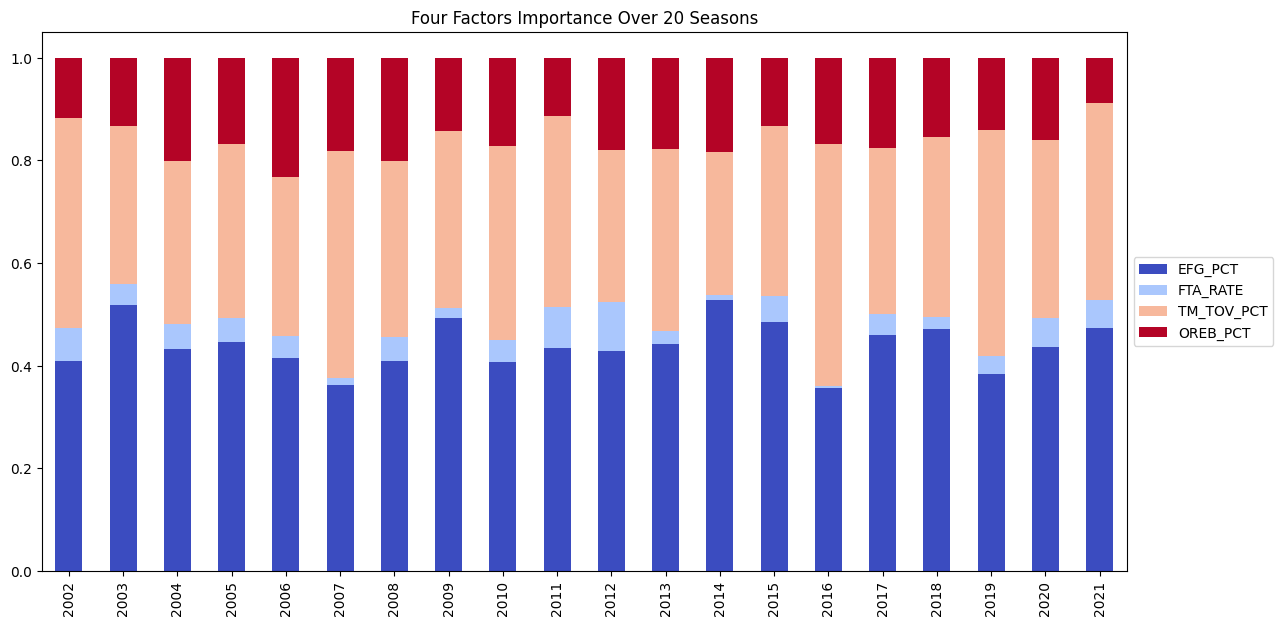

In [ ]:
four_factors_models.plot.bar(
    stacked=True, cmap="coolwarm",
    figsize=(14, 7),
    title="Four Factors Importance Over 20 Seasons",
).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

- The plot visualizes the importance of Four Factors over 20 NBA seasons. The bars represent different categories, stacked on top of each other to show their contribution to the total. The colormap "coolwarm" determines the color sequence of the bars. Additionally, the plot includes a title describing its purpose and a legend positioned to the left of the plot for clarity.

In [ ]:
# Get the argument for the closest row to the distribution above.
argmin = np.argmin(np.linalg.norm((four_factors_models - np.array([0.4, 0.15, 0.25, 0.20])), axis=1))
# Show the Series corresponding to that argument.
four_factors_models.iloc[argmin]

EFG_PCT       0.429392
FTA_RATE      0.095517
TM_TOV_PCT    0.295126
OREB_PCT      0.179964
Name: 2012, dtype: float64


The Four Factors can give us a good estimation of what it takes to win NBA games, and can be useful for teams to figure out what they may be lacking, in order to get in the best shape for the next season. Thanks to the NBA Stats API we can put all this data into a DataFrame and get even more insights.

In [ ]:
four_factors.loc[four_factors["season"] == 2021].sort_values(by="TM_TOV_PCT", ascending=False)[["TEAM_NAME", "TM_TOV_PCT"]].head(5)

,TEAM_NAME,TM_TOV_PCT
20,Oklahoma City Thunder,0.158
5,Cleveland Cavaliers,0.157
13,Los Angeles Lakers,0.152
4,Chicago Bulls,0.151
8,Detroit Pistons,0.151


- It sorts these filtered results based on the "TM_TOV_PCT" column in descending order, which likely represents turnover percentage. The head(5) function is used to retrieve the first five rows of the sorted DataFrame. Finally, it selects only the "TEAM_NAME" and "TM_TOV_PCT" columns from these top five rows.

Summary:

- This data experiment explores NBA outcomes using a chosen classifier. This data experiment can be done differently through combining multiple classifiers like stacking and bagging. This will enhance the predictive performance overall. With the success of my notebook, I believe this can used in different ways. This can include teams using these codes for game strategy. Teams can optimize their shot quality by calculatinhg the best shot quality using Python and numpy. There isn't much about this classifier that is inadequate. However, the classifier’s performance may benefit from fine-tuning to ensure data clanliness and addressing different outliers in data from historic performances in the NBA.

References

Biedma, L. (n.d.). NBA Stats Analysis Images. GitHub. NBA Stats Analysis Images on GitHub1.

Biedma, L. (n.d.). Four Factors Analysis. GitHub. Four Factors Analysis on GitHub1.

Walsh, Wyatt, 6 July 2023, https://www.kaggle.com/datasets/wyattowalsh/basketball
